In [1]:
import pandas as pd
import numpy as np
import processing.scales as scales

# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

scale_titles = scales.scale_titles

plots_path = '../plots/multivariate_analysis/'

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())
print('\n')

# compute basic statistics for later tests
N = len(data)
p = len(tia_scales)
k = data['stimulus_group'].nunique()

# set alpha and power
alpha = 0.05
power = 0.80

print(f'Sample size: N = {N}')
print(f'Number of outcomes: p = {p}')
print(f'Number of groups: k = {k}')

Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


Sample size: N = 255
Number of outcomes: p = 5
Number of groups: k = 2


## Data Preparation

### Variable Centering and Coding

We prepare variables for moderation analysis:

1. **Effect code treatment**: stimulus_group as -0.5 (control) and 0.5 (uncertainty)
2. **Standardize continuous variables**: For better comparison of beta values between variables
3. **Effect code categorical variables**: For symmetric interpretation

In [2]:
# 1. Effect code treatment: control = -0.5, uncertainty = 0.5
data['group_effect'] = data['stimulus_group'] - 0.5

# 2. Normalize all continuous variables
continuous_vars = hcsds_scales + ati_scales + tia_scales + ['age', 'page_submit']

for var in continuous_vars:
    data[f'{var}_c'] = (data[var] - data[var].mean())/data[var].std()

# 3. Effect code gender: male (1) = 0.5, female (2) = -0.5, "other/prefer not to say" (3) = 0
data['gender_c'] = data['gender'].map({1: 0.5, 2: -0.5, 3: 0})

# 4. Mean-center ordinal variables (education, AI experience)
data['education_c'] = data['education'] - data['education'].mean()
data['Q19_c'] = data['Q19'] - data['Q19'].mean()

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 10
Total moderators to test: 13


## Descriptive Statistics

Before running inferential tests, examine the data:
- Means, SDs, and ranges for each trust subscale by experimental condition
- Correlation matrix for the 5 TiA subscales (to see how they relate)
- Sample sizes per group

**Note**: We use the 5 core TiA subscales as DVs: `tia_f`, `tia_pro`, `tia_rc`, `tia_t`, `tia_up`

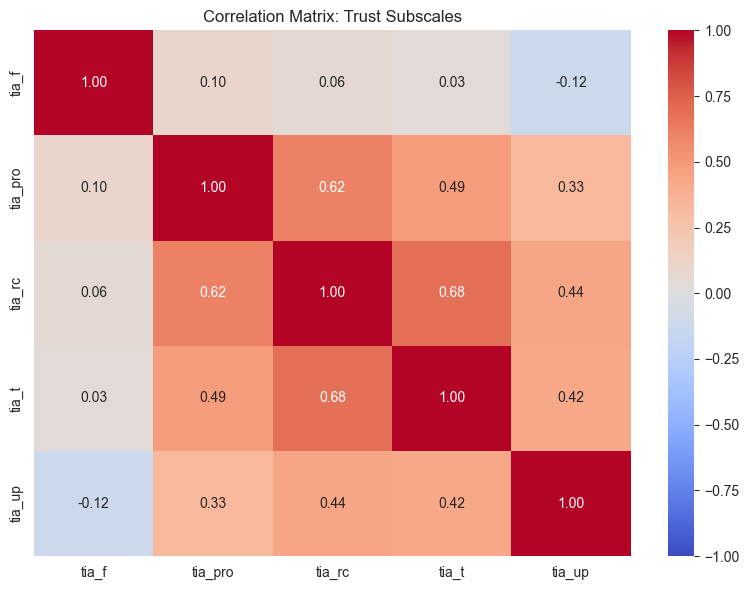

In [3]:
# Define the 5 core TiA subscales as dependent variables
dvs = tia_scales

# Correlation matrix for DVs: Shows how the 5 trust subscales relate to each other
corr_matrix = data[dvs].corr()

# Visualize with heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix: Trust Subscales')
plt.tight_layout()
plt.savefig(f'{plots_path}tia_corr_matrix.png')
plt.show()

## Assumption Checks

MANOVA assumptions to verify:
1. **Univariate normality** - Shapiro-Wilk test + visual inspection (histograms, Q-Q plots)
2. **Multivariate outliers** - Mahalanobis distance (flag cases with p < .001)
3. **Homogeneity of covariance matrices** - Box's M test (if violated, use Pillai's Trace instead of Wilks' Lambda)
4. **Multicollinearity** - VIF for predictors (should be < 10, especially after adding interactions)

tia_f: W = 0.907, p = 0.000
tia_pro: W = 0.964, p = 0.000
tia_rc: W = 0.960, p = 0.000
tia_t: W = 0.942, p = 0.000
tia_up: W = 0.978, p = 0.001


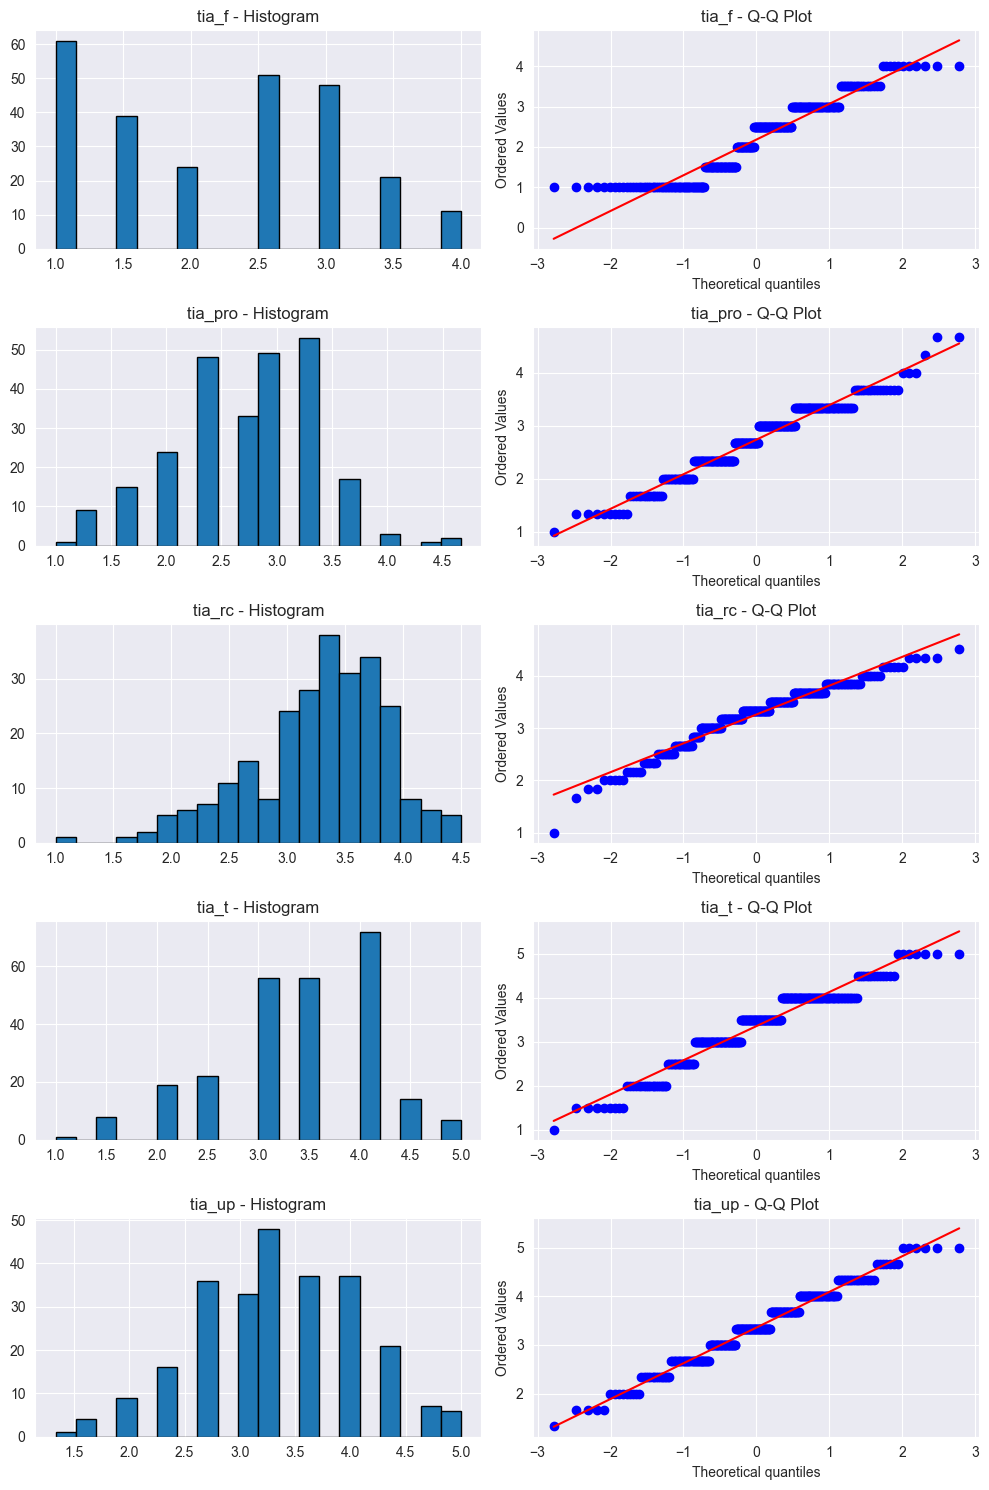

Multivariate outliers (p < .001): 1
       Variable       VIF
1  group_effect  1.008038
2         age_c  1.042640
3   education_c  1.076576
4         ati_c  1.011195
5     hcsds_c_c  1.611826
6     hcsds_v_c  1.553500


In [4]:
from scipy import stats
from scipy.spatial.distance import mahalanobis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# --- 3.1 Univariate Normality ---
# Shapiro-Wilk test for each DV (p < .05 suggests non-normality)
for dv in dvs:
    stat, pval = stats.shapiro(data[dv])
    print(f"{dv}: W = {stat:.3f}, p = {pval:.3f}")

# Visual: Histograms with Q-Q plots
fig, axes = plt.subplots(len(dvs), 2, figsize=(10, 3*len(dvs)))
for i, dv in enumerate(dvs):
    axes[i, 0].hist(data[dv], bins=20, edgecolor='black')
    axes[i, 0].set_title(f'{dv} - Histogram')
    stats.probplot(data[dv], plot=axes[i, 1])
    axes[i, 1].set_title(f'{dv} - Q-Q Plot')
plt.tight_layout()
plt.savefig(f'{plots_path}tia_normality.png')
plt.show()

# --- 3.2 Multivariate Outliers (Mahalanobis Distance) ---
def calc_mahalanobis(df, vars):
    """Calculate Mahalanobis distance for each observation."""
    X = df[vars].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X.T)
    cov_inv = np.linalg.inv(cov)
    distances = [mahalanobis(x, mean, cov_inv) for x in X]
    return distances

data['mahal_dist'] = calc_mahalanobis(data, dvs)
data['mahal_p'] = 1 - stats.chi2.cdf(data['mahal_dist']**2, df=len(dvs))
outliers = data[data['mahal_p'] < 0.001]
print(f"Multivariate outliers (p < .001): {len(outliers)}")

# --- 3.3 Homogeneity of Covariance (Box's M) ---
# Note: Box's M is sensitive to non-normality. If significant, use Pillai's Trace.
def boxs_m_test(data, dvs, group_var):
    """Manual Box's M test implementation."""
    # This is complex - consider using pingouin.box_m() or
    # just note to use Pillai's Trace if in doubt
    pass

# Alternative: Just use Pillai's Trace (more robust) by default

# --- 3.4 Multicollinearity (VIF) ---
# Check VIF for predictors in the full model
predictors = ['group_effect', 'age_c', 'education_c', 'ati_c', 'hcsds_c_c', 'hcsds_v_c']
X = data[predictors]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data[vif_data['Variable'] != 'const'])

## MANOVA Models Selection

### Forward selection to select variables.

Use `statsmodels.multivariate.manova.MANOVA` for multivariate tests.

In [5]:
from statsmodels.multivariate.manova import MANOVA

# Define DV string for MANOVA formula
dv_formula = ' + '.join(dvs)  # 'tia_f + tia_pro + tia_rc + tia_t + tia_up'

manova_models = [0] *4

# --- Model 1: Condition only ---
formula_m1 = f'{dv_formula} ~ group_effect'
manova_models[0] = MANOVA.from_formula(formula_m1, data=data)

# --- Model 2: + Demographics ---
formula_m2 = f'{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c'
manova_models[1] = MANOVA.from_formula(formula_m2, data=data)

# --- Model 3: + Psychometric scales ---
formula_m3 = f'{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c + ati_c + hcsds_c_c + hcsds_v_c'
manova_models[2] = MANOVA.from_formula(formula_m3, data=data)

# --- Model 4: + Interactions (moderation) ---
# Note: statsmodels formula syntax uses ':' for interactions
formula_m4 = f'''{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c + ati_c + hcsds_c_c + hcsds_v_c
                 + group_effect:age_c + group_effect:education_c  + group_effect:gender_c
                 + group_effect:ati_c + group_effect:hcsds_c_c + group_effect:hcsds_v_c'''
manova_models[3] = MANOVA.from_formula(formula_m4, data=data)

In [6]:
# --- Extract test statistics from MANOVA results ---
# The mv_test() method returns a MultivariateTestResults object
# Access specific tests via: result.results['effect_name']['stat']

# df_e (within group df) = 'Den DF'
# df_h (between group df) = 'Num DF'

mv_results = []

for (i, model) in enumerate(manova_models):
    r = model.mv_test()
    print(f'=== MANOVA model {i + 1} ===')

    # go through all effects
    for effect in r.results:
        if not effect == 'Intercept':
            print(f"\n=== {effect} ===")
            result_df = r.results[effect]['stat']
            pillai = result_df.loc["Pillai's trace"]

            print(f"Pillai's Trace = {pillai['Value']:.4f}")
            print(f"F({pillai['Num DF']:.0f}, {pillai['Den DF']:.0f}) = {pillai['F Value']:.3f}")

            # Calculate partial η² for multivariate effect
            partial_eta_sq = (pillai['F Value'] * pillai['Num DF']) / (pillai['F Value'] * pillai['Num DF'] + pillai['Den DF'])
            print(f"Partial eta2 = {partial_eta_sq:.4f}")

            # Calculate p-value and show marker for significance
            pval = pillai['Pr > F']
            sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''

            print(f"p = {pval:.4f} {sig}")

            mv_results.append({
                'model': (i+1),
                'effect': effect,
                'pillai value': pillai['Value'],
                'F Value': pillai['F Value'],
                'Num DF': pillai['Num DF'],
                'Den DF': pillai['Den DF'],
                'partial_eta_sq': partial_eta_sq,
                'p': pval,
                'sig': sig if not sig == '' else 'not significant'
            })

    print(f'\n{'='*22}\n\n')

mv_results_df = pd.DataFrame(mv_results)

# show significant results
# mv_results_df[mv_results_df['p'] < 0.05]

for i, row in mv_results_df[mv_results_df['p'] < 0.05].iterrows():
    print(f'Model {row['model']}: {row['effect']}\n partial_eta2 = {row['partial_eta_sq']:.4f}  p = {row['p']:.4f} ({row['sig']})\n')

=== MANOVA model 1 ===

=== group_effect ===
Pillai's Trace = 0.0199
F(5, 249) = 1.013
Partial eta2 = 0.0199
p = 0.4106 



=== MANOVA model 2 ===

=== group_effect ===
Pillai's Trace = 0.0232
F(5, 245) = 1.163
Partial eta2 = 0.0232
p = 0.3278 

=== age_c ===
Pillai's Trace = 0.1667
F(5, 245) = 9.803
Partial eta2 = 0.1667
p = 0.0000 ***

=== education_c ===
Pillai's Trace = 0.0774
F(5, 245) = 4.109
Partial eta2 = 0.0774
p = 0.0013 **

=== gender_c ===
Pillai's Trace = 0.0180
F(5, 245) = 0.897
Partial eta2 = 0.0180
p = 0.4834 

=== Q19_c ===
Pillai's Trace = 0.0824
F(5, 245) = 4.399
Partial eta2 = 0.0824
p = 0.0007 ***



=== MANOVA model 3 ===

=== group_effect ===
Pillai's Trace = 0.0217
F(5, 242) = 1.074
Partial eta2 = 0.0217
p = 0.3752 

=== age_c ===
Pillai's Trace = 0.1843
F(5, 242) = 10.938
Partial eta2 = 0.1843
p = 0.0000 ***

=== education_c ===
Pillai's Trace = 0.0724
F(5, 242) = 3.780
Partial eta2 = 0.0724
p = 0.0026 **

=== gender_c ===
Pillai's Trace = 0.0117
F(5, 242) = 0.

### Conclusion Model Selection
No new variables reach significance in model 4. Therefore, interaction effects do no increase the fit of the model and can be left out.

In [7]:
multivariate_model = manova_models[2]
multivariate_model_results = mv_results_df[mv_results_df['model'] == 3]

## 5b. Multivariate Non-Inferiority Test (MANOVA)

Before testing each subscale individually, we can assess non-inferiority for the **collective set of trust outcomes** using a multivariate approach based on MANOVA.

### Mathematical Framework

**Effect Size Relationships in MANOVA:**

For a two-group comparison (single degree of freedom effect):
- **Pillai's Trace (V)** equals partial η² and ranges from 0 to 1
- **Cohen's f²** relates to V by: $f^2 = \frac{V}{1-V}$
- Converting back: $V = \frac{f^2}{1+f^2}$

**The F-test for Pillai's V:**

$$F = \frac{V}{1-V} \times \frac{df_2}{df_1}$$

Where $df_1 = p$ (number of DVs = 5) and $df_2 = N - p - 1$ (= 249 for our data).

**Non-centrality parameter (λ):**

$$\lambda = N \times \frac{V}{1-V}$$

This connects sample size and effect size to power. To find the MDE, we solve for λ such that:

$$P(F_{nc}(df_1, df_2, \lambda) > F_{crit}) = \text{power}$$

**Non-Inferiority Logic:**

Since Pillai's V is always positive (variance-based), we use **practical equivalence** reasoning:
1. Calculate V_mde: the smallest Pillai's V detectable with 80% power
2. Construct a confidence interval for the true V
3. If the upper bound of this CI is below V_mde, conclude non-inferiority

This is analogous to checking "the effect is small enough that we would have detected it if it were meaningful."

In [8]:
# find MDE (minimally detectable effect) in a MANOVA
import numpy as np
from scipy.stats import f, ncf
from scipy.optimize import bisect

def manova_sensitivity_analysis(alpha, power, N, k, p):
    """
    Compute minimally detectable effect size for MANOVA.

    Parameters:
    -----------
    alpha : float - significance level
    power : float - desired power (1-β)
    N : int - total sample size
    k : int - number of groups
    p : int - number of dependent variables

    Returns:
    --------
    dict with effect sizes (Pillai's V, Cohen's f², partial η²)
    """

    # Step 1: Degrees of freedom
    df_h = k - 1
    df_e = N - k
    s = min(df_h, p)
    m = (abs(df_h - p) - 1) / 2
    n = (df_e - p - 1) / 2

    # Step 2: F-distribution df
    df1 = s * (2*m + s + 1)
    df2 = s * (2*n + s + 1)

    # Step 3: Critical F-value
    F_crit = f.ppf(1 - alpha, df1, df2)

    # Step 4: Find non-centrality parameter
    def power_diff(lambda_nc):
        computed_power = 1 - ncf.cdf(F_crit, df1, df2, lambda_nc)
        return computed_power - power

    # Search for lambda between 0 and 1000
    lambda_nc = bisect(power_diff, 0.001, 1000)

    # Step 5: Convert to effect sizes
    # Pillai's trace
    V = (lambda_nc * s) / (df_e + lambda_nc)

    # Cohen's f²
    f_squared = lambda_nc / N

    # Partial η²
    eta_squared_p = lambda_nc / (lambda_nc + df_e)

    return {
        'lambda': lambda_nc,
        'Pillais_V': V,
        'Cohens_f_squared': f_squared,
        'partial_eta_squared': eta_squared_p,
        'df1': df1,
        'df2': df2,
        'F_crit': F_crit
    }

# Example with your parameters
result = manova_sensitivity_analysis(
    alpha=alpha,
    power=power,
    N=N,
    k=k,
    p=p
)

eq_margin = result['partial_eta_squared']

print(f"Non-centrality parameter: {result['lambda']:.4f}")
print(f"Pillai's V: {result['Pillais_V']:.4f}")
print(f"Cohen's f²: {result['Cohens_f_squared']:.4f}")
print(f"Critical F: {result['F_crit']:.4f}")
print(f"Partial η²: {result['partial_eta_squared']:.4f}")

print(f'{'='*20}\nEquivalence margin: {eq_margin:.4f}')

Non-centrality parameter: 13.1152
Pillai's V: 0.0493
Cohen's f²: 0.0514
Critical F: 2.2503
Partial η²: 0.0493
Equivalence margin: 0.0493


In [9]:
from scipy import stats as scipy_stats
from scipy.optimize import brentq

def manova_confidence_interval(F_obs, n, p, k=2, alpha=0.05):
    """
    Calculate confidence interval for the observed F-value using non-central F inversion.

    For a two-group MANOVA, we invert the F-test to get CIs for the
    non-centrality parameter, then convert to V.

    The method finds lambda bounds such that F_obs falls at the appropriate
    quantiles of the non-central F distribution:
    - Lower bound: F_obs is at the (1-α/2) quantile → small lambda
    - Upper bound: F_obs is at the (α/2) quantile → large lambda

    Parameters:
    -----------
    F_obs : float
        Observed F-value (using Pillai's V)
    n : int
        Total sample size
    p : int
        Number of dependent variables
    k : int
        Number of groups
    alpha : float
        Significance level for CI (default 0.05 for 95% CI)

    Returns:
    --------
    dict with CI bounds for V and related statistics
    """
    df1 = p
    df2 = n - p - 1
    df_W = n - k

    # For confidence intervals on non-centrality parameter:
    #
    # Lower bound (ncp_L): F_obs should be at (1-α/2) quantile
    #   → CDF(F_obs | ncp_L) = 1 - α/2, i.e., SF(F_obs | ncp_L) = α/2
    #   → As ncp decreases, SF decreases; we need low ncp
    #
    # Upper bound (ncp_U): F_obs should be at (α/2) quantile
    #   → CDF(F_obs | ncp_U) = α/2, i.e., SF(F_obs | ncp_U) = 1 - α/2
    #   → As ncp increases, SF increases; we need high ncp

    # Check if we can establish a lower bound > 0
    # SF at lambda=0 tells us if F_obs is in the upper tail of central F
    sf_at_zero = scipy_stats.f.sf(F_obs, df1, df2)

    # Lower bound for ncp: find ncp where SF(F_obs) = α/2
    def lower_func(lambda_nc):
        return scipy_stats.ncf.sf(F_obs, df1, df2, lambda_nc) - alpha/2

    lambda_lower = 0
    if sf_at_zero < alpha/2:
        # F_obs is large enough that even at ncp=0, it's in the upper tail
        # We can find a positive lower bound
        try:
            lambda_lower = brentq(lower_func, 0, 500)
        except ValueError:
            lambda_lower = 0

    # Upper bound for ncp: find ncp where SF(F_obs) = 1 - α/2
    def upper_func(lambda_nc):
        return scipy_stats.ncf.sf(F_obs, df1, df2, lambda_nc) - (1 - alpha/2)

    try:
        # Start search from a small positive value
        lambda_upper = brentq(upper_func, 0.001, 1000)
    except ValueError:
        # If brentq fails, try a wider range or use fallback
        try:
            lambda_upper = brentq(upper_func, 0.0001, 5000)
        except ValueError:
            lambda_upper = float('inf')

    # Convert ncp bounds to eta_squared bounds
    # V = ncp / (df_error + ncp)
    eta_sq_lower = lambda_lower / (df_W + lambda_lower) if lambda_lower > 0 else 0
    eta_sq_upper = lambda_upper / (df_W + lambda_upper) if lambda_upper < float('inf') else 1

    return {
        'F_obs': F_obs,
        'eta_sq_lower': eta_sq_lower,
        'eta_sq_upper': eta_sq_upper,
        'lambda_lower': lambda_lower,
        'lambda_upper': lambda_upper,
        'df1': df1,
        'df2': df2,
        'sf_at_zero': sf_at_zero  # p-value, useful for debugging
    }


Non-Inferiority Test Results for 'Multivariate Effect':
  Effect size: 0.0217
  95% CI: [0.0000, 0.0483]
  SESOI margin: 0.0493
  (p-value: N/A)
  Result: Non-inferiority established



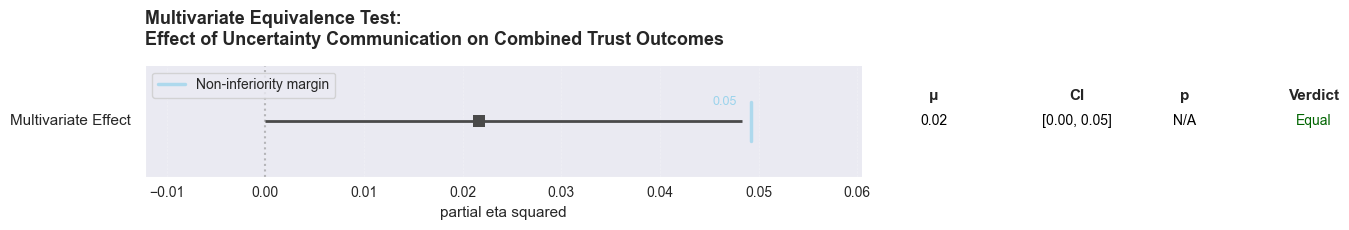

In [10]:
from scripts.viz_utils import plot_noninferiority_test

# Compute confidence interval around observed F value
F_obs = multivariate_model_results[multivariate_model_results['effect'] == 'group_effect']['F Value'].values[0]
eta_sq_obs = multivariate_model_results[multivariate_model_results['effect'] == 'group_effect']['partial_eta_sq'].values[0]

ci_results = manova_confidence_interval(
    F_obs=F_obs,
    alpha=alpha,
    n=N,
    k=k,
    p=p
)

# compute p-value for equivalence test


# Use pre-computed CI bounds from the F-distribution (not assuming normality)
fig, ax = plt.subplots(figsize=(10, 5))
plot_noninferiority_test(
    effect_size=eta_sq_obs,
    sesoi=eq_margin,
    ci_lower_bounds=ci_results['eta_sq_lower'],  # Pre-computed from F-distribution
    ci_upper_bounds=ci_results['eta_sq_upper'],
    alpha=alpha,
    test_type='upper',  # Non-inferiority means effect < margin
    mode = 'equivalence',
    variable_names=['multivariate'],
    variable_labels={'multivariate': 'Multivariate Effect'},
    title='Multivariate Equivalence Test:\nEffect of Uncertainty Communication on Combined Trust Outcomes',
    xlabel="partial eta squared",
    height_scale=0.3,
    column_title_pos_shift=-0.2,
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}multivariate_equivalence_test.png', dpi=150, transparent=True)
plt.show()